In [12]:
from random import choice
from pprint import pprint

# Enumerating the sentences in a context-free grammar
## (In order of complexity)

Imagine you have a context-free grammar and you want to go through (some of) the sentences in the grammar in order of complexity. How to do this? It turns out there's a neat little python trick that allows us to do it in just a few lines of code.

There's a couple of bits of knowledge needed to understand the final piece of code: 
1. representing a context free grammar as a dict of lists.
1. recursive functions.
1. generators & generator delegation.

Let's go through them in turn.

## CFG

A context free grammar consists of\* four ingredients:

1. A set of non-terminal symbols. Conceptually, these are the 'types' of expressions that can appear in our language.
1. A set of terminal symbols. The saturated sentences are going to consist only of terminal symbols.
1. A starting symbol, let's call it `<S>` (for 'sentence'), which is also included in the set of non-terminals.
1. A set of substitution rules with the following structure:
$$
A \rightarrow \alpha
$$
where $A$ is a non-terminal symbols and $\alpha$ is some expression consisting of terminals and non-terminals.

A sentence in the grammar is constructed by progressively substituting non-terminals according to the list of substitution rules until only terminals are left.

\* The technical definition has more stuff but just to get an idea.

To represent a grammar in python, all we really need is the list of substitution rules, which implicitly tells us what symbols are terminals and which aren't. The basic idea is to use a dictionary whose keys are the non-terminals, and whose values are the possible strings that the terminal can be substituted with. 

For instance, we can encode propositional logic with negation, conjunction, and disjunction as:

In [74]:
grammar = {
    '<S>': [
        'P',
        'Q',
        'NOT(<S>)',
        'AND(<S>,<S>)',
        'OR(<S>,<S>)'
    ]
}

This means that we start with a 'sentence'-type stuff, and any sentence can be expanded directly into a terminal ('P' or 'Q') or something that itself contains a 'sentence'-type stuff. This recursive structure is what makes cfg powerful: they define an infinite set of sentences.

Note that as a matter of convention, I am writing non-terminals surrounded by '<' and '>'. This makes it easier to find non-terminals when recursively constructing a sentence.

We can construct a sentence with this grammar as follows. 
- We start with `<S>`:
```
<S>
```
- We substitute `<S>` with `OR(<S>,<S>)`, obtaining:
```
OR(<S>,<S>)
```
- Then, we substitute the first occurrence of `<S>` with `NOT(<S>)`:
```
OR(NOT(<S>),<S>)
```
- Then, we substitute the new occurrence of `<S>` in the new sentence with `P`:
```
OR(NOT(P),<S>)
```
- Finally, we substitute the remaining non-terminal `<S>` with `Q`:
```
OR(NOT(P),Q)
```
And we are left with no non-terminals!

## Recursive functions

A recursive function is just a function that calls itself, with possible different parameters from the original call. It seems natural that the recursive way in which sentences are constructed by a cfg can be implemented by a recursive function. Let's consider how we would construct a function to produce a random sentence generated by the grammar.

Procedurally, we can do it as follows:
- We write a function that takes an expressions that can contain terminals or non-terminals
- If the expression contains non-terminals, the leftmost non-terminal is substituted by an expression according to the grammar producing a new expression, then the function itself is called on the new expression. Finally, the result of calling the function is returned.
    - Note that while the new expression will sometimes have more non-terminals than it began with, once a non-terminal is substituted for a terminal, it will never become a non-terminal again.
- If the expression does not contain any terminal, it is simply returned.

This function takes an expression, finds the leftmost non-terminal, and divides what is before the nonterminal, the nonterminal, and what is after the nonterminal:

In [19]:
def split_expression(expression):
    start_i, end_i = expression.index('<'), expression.index('>')+1
    nonterminal = expression[start_i:end_i]
    return expression[:start_i], nonterminal, expression[end_i:]

In [6]:
def create_random_sentence(expression, grammar):
    if '<' in expression:
        before_nont, nont, after_nont = split_expression(expression)
        substitution = choice(grammar[nont])
        new_expression = before_nont + substitution + after_nont
        return create_random_sentence(new_expression, grammar)
    else:
        return expression

Let's test this function:

In [13]:
pprint([create_random_sentence('<S>', grammar) for _ in range(10)])

['NOT(P)',
 'Q',
 'P',
 'P',
 'P',
 'AND(NOT(OR(OR(P,P)),OR(Q,NOT(AND(P,AND(OR(AND(P,P),NOT(Q))),OR(Q,OR(Q,Q)))))))))))),Q)',
 'OR(P,P))',
 'AND(NOT(OR(NOT(Q),AND(NOT(AND(NOT(OR(AND(P,Q),P))),P)),Q)))),NOT(AND(NOT(NOT(P)),P)))',
 'Q',
 'Q']


This produces random sentences in the grammar. But suppose we want instead to consider _all_ the sentences in the grammar by enumerating them. How do we do this? If all we have are recursive functions, it's not so easy at all! - I am not going to go through examples in the interest of time, but try and this how you'd do it. 

Anyway, this is where generators come to the rescue. 

## Generators and delegation

A generator in python is, roughly, a function that after returning something isn't just forgotten like usual functions, but rather remembers its state and can keep returning other things in a way that is specified when the generator is defined. Within the generator, we can tell it when and what to return with the keyword `yield`. First, the generator function is defined, and then values are returned when we call `next` on it. 

For example, suppose you want a generator that just produces successive integers. You could define it as follows:

In [14]:
def generate_ints():
    integer = 0
    while True:
        yield integer
        integer += 1

And we get values from the generator as follows:

In [17]:
gen = generate_ints()
for i in range(10):
    print(next(gen), end=' ')

0 1 2 3 4 5 6 7 8 9 

Generators are useful, among other things, because they allow you to consider a potentially infinite series of objects one by one in a way that is encapsulated in a function object. We couldn't do this easily with just a function that returns a list, since lists can't be infinite!

How does this apply to grammars? Well, we want to enumerate the sentences, and there are infinitely many of them, so a generator is a natural choice. One intuitive way of generating sentences is as follows:
- We start with a 'layer' that contains only the simplest expressions, `<S>`
- We apply all rules to the leftmost nonterminal. When a sentence is a terminal, we yield it, and otherwise we add it to the new layer.
- We then apply the function itself to the new layer.
This is going to be a recursive structure because we call the function itself on the new layer created in the function.

Since each sentence can be reached by some application of the rules in some order, this will eventually give us any sentence. Intuitively, it works like this:
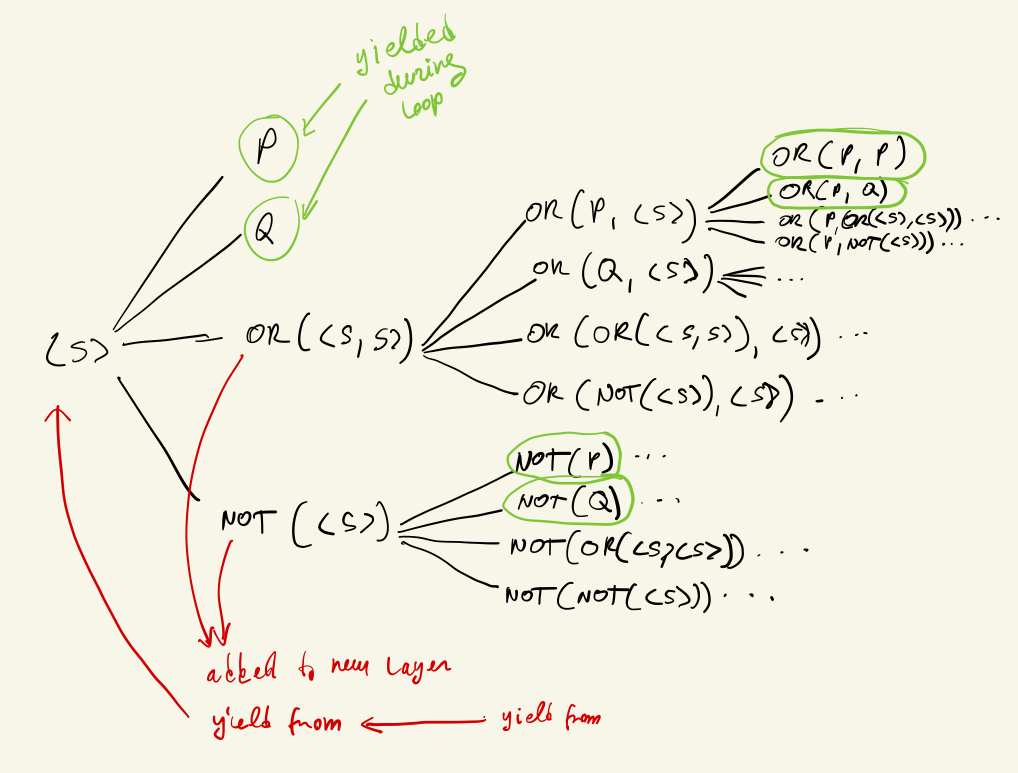

However, note that if we try to yield the function itself, we just yield an iterator, which is not what we want: we want to yield a string. So instead we can either loop over the result of the function or used so-called 'generator delegation', which 'gives control' to the generator: the generator yields whatever is being yielded by the other generator instead.

We can write the whole function in just a few lines:

In [32]:
def enumerate_grammar(present, grammar):
    layer = []
    for element in present:
        if '<' in element:
            before_nonterminal, nonterminal, after_nonterminal = split_expression(element)
            for completion in grammar[nonterminal]:
                layer.append(before_nonterminal+completion+after_nonterminal)
        else:
            yield element
    yield from enumerate_grammar(layer, grammar)
#     for i in enumerate_grammar(layer, grammar):
#         yield i

And to see how it works:

In [35]:
gen = enumerate_grammar(['<S>'], grammar)

for i in range(50):
    print(next(gen))

P
Q
NOT(P)
NOT(Q)
NOT(NOT(P))
NOT(NOT(Q))
AND(P,P)
AND(P,Q)
AND(Q,P)
AND(Q,Q)
OR(P,P))
OR(P,Q))
OR(Q,P))
OR(Q,Q))
NOT(NOT(NOT(P)))
NOT(NOT(NOT(Q)))
NOT(AND(P,P))
NOT(AND(P,Q))
NOT(AND(Q,P))
NOT(AND(Q,Q))
NOT(OR(P,P)))
NOT(OR(P,Q)))
NOT(OR(Q,P)))
NOT(OR(Q,Q)))
AND(P,NOT(P))
AND(P,NOT(Q))
AND(Q,NOT(P))
AND(Q,NOT(Q))
AND(NOT(P),P)
AND(NOT(P),Q)
AND(NOT(Q),P)
AND(NOT(Q),Q)
OR(P,NOT(P)))
OR(P,NOT(Q)))
OR(Q,NOT(P)))
OR(Q,NOT(Q)))
OR(NOT(P),P))
OR(NOT(P),Q))
OR(NOT(Q),P))
OR(NOT(Q),Q))
NOT(NOT(NOT(NOT(P))))
NOT(NOT(NOT(NOT(Q))))
NOT(NOT(AND(P,P)))
NOT(NOT(AND(P,Q)))
NOT(NOT(AND(Q,P)))
NOT(NOT(AND(Q,Q)))
NOT(NOT(OR(P,P))))
NOT(NOT(OR(P,Q))))
NOT(NOT(OR(Q,P))))
NOT(NOT(OR(Q,Q))))


### Bonus: a BRUTAL way of finding minimal formulas

(Don't use irl!)

In [55]:
def AND(x, y):
    return x & y

def OR(x, y):
    return x | y

def NOT(n, numbits=4):
    # taken from 
    # https://stackoverflow.com/questions/31151107/how-do-i-do-a-bitwise-not-operation-in-python
    return (1 << numbits) - 1 - n

P = 0b0011
Q = 0b0101

In [82]:
# example
bin(OR(0b1010, 0b1111))

'0b1111'

In [80]:
minimal_fs = dict()
def generate_minimal_formulas(present, grammar):
    layer = []
    for element in present:
        if '<' in element:
            before_nonterminal, nonterminal, after_nonterminal = split_expression(element)
            for completion in grammar[nonterminal]:
                layer.append(before_nonterminal+completion+after_nonterminal)
        else:
            meaning = eval(element)
            if meaning not in minimal_fs:
                minimal_fs[meaning] = element
                if len(minimal_fs) == 16:
                    return None
    generate_minimal_formulas(layer, grammar)

In [78]:
generate_minimal_formulas(['<S>'], grammar)

finished!


In [79]:
minimal_fs 

{3: 'P',
 5: 'Q',
 12: 'NOT(P)',
 10: 'NOT(Q)',
 1: 'AND(P,Q)',
 7: 'OR(P,Q)',
 14: 'NOT(AND(P,Q))',
 8: 'NOT(OR(P,Q))',
 0: 'AND(P,NOT(P))',
 2: 'AND(P,NOT(Q))',
 4: 'AND(Q,NOT(P))',
 15: 'OR(P,NOT(P))',
 11: 'OR(P,NOT(Q))',
 13: 'OR(Q,NOT(P))',
 6: 'AND(NOT(AND(P,Q)),OR(P,Q))',
 9: 'OR(NOT(OR(P,Q)),AND(P,Q))'}